In [1]:
#import dependecies
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings('ignore')

import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

#import dependencies for ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import validation_curve
import math
from math import sqrt


#import dependencies for graphs
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_context("paper")


In [2]:
#connect to a sqlite3 db
conn = sqlite3.connect(r'/Users/rosaicelaroman/Desktop/portfolio_work/earthquake_modeling/Database/db/earthquake_db')
print("Connected to database...")

Connected to database...


In [3]:
#create dataframe reading all rows from sqlite database
model_df = pd.read_sql_query("SELECT * FROM earthquake_raw", conn)
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06T01:42:39.855Z,37.384000,-117.107500,1.10,1.30,ml,8.0,149.46,0.875000,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290000,4.0,automatic,nn,nn
1,2022-01-06T01:31:33.698Z,38.181000,-117.818000,7.30,1.40,ml,11.0,154.64,0.119000,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460000,5.0,automatic,nn,nn
2,2022-01-06T01:24:20.083Z,61.340700,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06T01:15:15.851Z,62.870300,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06T01:10:44.629Z,64.014500,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44892,2022-03-21T04:48:46.720Z,38.823833,-122.808000,3.90,0.43,md,14.0,98.00,0.001678,0.0400,...,2022-03-21T20:17:52.874Z,"7km NW of The Geysers, CA",earthquake,0.39,0.28,0.151000,3.0,reviewed,nc,nc
44893,2022-03-21T04:46:01.380Z,38.821835,-122.760834,1.85,0.85,md,7.0,127.00,0.011170,0.0100,...,2022-03-21T05:29:21.342Z,"3km W of Cobb, CA",earthquake,0.48,0.96,NaN,1.0,automatic,nc,nc
44894,2022-03-21T04:41:58.710Z,19.870000,-155.577000,20.18,1.63,md,24.0,120.00,NaN,0.1500,...,2022-03-22T00:38:03.450Z,"19 km SSE of Waimea, Hawaii",earthquake,0.46,0.99,0.124445,15.0,reviewed,hv,hv
44895,2022-03-21T04:39:20.420Z,38.801666,-122.815498,3.22,0.35,md,7.0,161.00,0.012880,0.0100,...,2022-03-21T04:56:14.173Z,"6km WNW of The Geysers, CA",earthquake,0.59,1.06,NaN,1.0,automatic,nc,nc


In [4]:
#converting time to datetime
model_df['time'] = pd.to_datetime(model_df['time'])
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06 01:42:39.855000+00:00,37.384000,-117.107500,1.10,1.30,ml,8.0,149.46,0.875000,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290000,4.0,automatic,nn,nn
1,2022-01-06 01:31:33.698000+00:00,38.181000,-117.818000,7.30,1.40,ml,11.0,154.64,0.119000,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460000,5.0,automatic,nn,nn
2,2022-01-06 01:24:20.083000+00:00,61.340700,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06 01:15:15.851000+00:00,62.870300,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06 01:10:44.629000+00:00,64.014500,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44892,2022-03-21 04:48:46.720000+00:00,38.823833,-122.808000,3.90,0.43,md,14.0,98.00,0.001678,0.0400,...,2022-03-21T20:17:52.874Z,"7km NW of The Geysers, CA",earthquake,0.39,0.28,0.151000,3.0,reviewed,nc,nc
44893,2022-03-21 04:46:01.380000+00:00,38.821835,-122.760834,1.85,0.85,md,7.0,127.00,0.011170,0.0100,...,2022-03-21T05:29:21.342Z,"3km W of Cobb, CA",earthquake,0.48,0.96,NaN,1.0,automatic,nc,nc
44894,2022-03-21 04:41:58.710000+00:00,19.870000,-155.577000,20.18,1.63,md,24.0,120.00,NaN,0.1500,...,2022-03-22T00:38:03.450Z,"19 km SSE of Waimea, Hawaii",earthquake,0.46,0.99,0.124445,15.0,reviewed,hv,hv
44895,2022-03-21 04:39:20.420000+00:00,38.801666,-122.815498,3.22,0.35,md,7.0,161.00,0.012880,0.0100,...,2022-03-21T04:56:14.173Z,"6km WNW of The Geysers, CA",earthquake,0.59,1.06,NaN,1.0,automatic,nc,nc


In [5]:
#adding column of converted time to datetime
model_df['Unix Time'] = pd.to_datetime(model_df['time']).astype(int)/10**9
model_df.head(5)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix Time
0,2022-01-06 01:42:39.855000+00:00,37.3840,-117.1075,1.1,1.3,ml,8.0,149.46,0.875,0.2175,...,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.29,4.0,automatic,nn,nn,1.641433e+09
1,2022-01-06 01:31:33.698000+00:00,38.1810,-117.8180,7.3,1.4,ml,11.0,154.64,0.119,0.1017,...,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.46,5.0,automatic,nn,nn,1.641433e+09
2,2022-01-06 01:24:20.083000+00:00,61.3407,-149.8852,30.0,1.5,ml,NaN,NaN,NaN,0.7500,...,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak,1.641432e+09
3,2022-01-06 01:15:15.851000+00:00,62.8703,-150.7625,111.3,2.1,ml,NaN,NaN,NaN,0.3200,...,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak,1.641432e+09
4,2022-01-06 01:10:44.629000+00:00,64.0145,-148.7657,1.9,1.5,ml,NaN,NaN,NaN,0.7200,...,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak,1.641431e+09


In [6]:
#review names of all columns (features)
for col in model_df.columns:
    print(col)

time
latitude
longitude
depth
mag
magType
nst
gap
dmin
rms
net
id
updated
place
type
horizontalError
depthError
magError
magNst
status
locationSource
magSource
Unix Time


In [7]:
#drop columns not needed
cleaned_df = model_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_df

,latitude,longitude,depth,mag,Unix Time
0,37.384000,-117.107500,1.10,1.30,1.641433e+09
1,38.181000,-117.818000,7.30,1.40,1.641433e+09
2,61.340700,-149.885200,30.00,1.50,1.641432e+09
3,62.870300,-150.762500,111.30,2.10,1.641432e+09
4,64.014500,-148.765700,1.90,1.50,1.641431e+09
...,...,...,...,...,...
44892,38.823833,-122.808000,3.90,0.43,1.647838e+09
44893,38.821835,-122.760834,1.85,0.85,1.647838e+09
44894,19.870000,-155.577000,20.18,1.63,1.647838e+09
44895,38.801666,-122.815498,3.22,0.35,1.647838e+09


In [8]:
#find if any column has NaNs
cleaned_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          6
Unix Time    0
dtype: int64

In [9]:
#drop NaNs
cleaned_df_dropped = cleaned_df.dropna()

In [10]:
#verify dropped NaNs
cleaned_df_dropped.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
Unix Time    0
dtype: int64

In [11]:
#establish features to be used in model. X will use: longitude, longitude, depth and unix time. Y will be magnitude
X = cleaned_df_dropped.drop(['longitude'], axis = 1)

y = cleaned_df_dropped[['longitude']]

In [12]:
#checking number of columns and rows for eacg feature
X.shape, y.shape

((44891, 4), (44891, 1))

In [13]:
#scale and transform the data
# sc_X = StandardScaler()
# sc_y = StandardScaler()
# X = X.fit_transform(X)
# y = y.fit_transform(y)

In [14]:
#split dataset into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Extra Trees Regressor

In [15]:
#create and run model: First with 50 estimators
scores = []
estimators_lst=[]

for i in range(1,50):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    scores.append(score)
    estimators_lst.append(score)

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2 score:", r2, end = ", ")
    print("\tModel score:", score)
max_score = max(scores)
print("Max score:", max_score)
index_max_score = scores.index(max_score) #find the position in the list for max score to get the number of estimators
best_score = max_score
best_model = ExtraTreesRegressor(n_estimators=index_max_score+2, random_state=0)
best_model.fit(X_train, y_train)
best_model_score = best_model.score(X_test, y_test)
print("Best model score: ", best_model_score)


n_estimators=2:
	Mean Squared Error: 1539.2072776961331, 	R2 score: 0.7213204429344701, 	Model score: 0.7213204429344701
n_estimators=3:
	Mean Squared Error: 1306.9920129044724, 	R2 score: 0.7633639338104081, 	Model score: 0.7633639338104081
n_estimators=4:
	Mean Squared Error: 1278.831247780806, 	R2 score: 0.7684625515632011, 	Model score: 0.7684625515632011
n_estimators=5:
	Mean Squared Error: 1225.311165737731, 	R2 score: 0.7781525738064687, 	Model score: 0.7781525738064687
n_estimators=6:
	Mean Squared Error: 1185.1273967449172, 	R2 score: 0.7854280038972767, 	Model score: 0.7854280038972767
n_estimators=7:
	Mean Squared Error: 1151.1202578429943, 	R2 score: 0.7915851307141658, 	Model score: 0.7915851307141658
n_estimators=8:
	Mean Squared Error: 1127.3878055803898, 	R2 score: 0.7958819849328652, 	Model score: 0.7958819849328652
n_estimators=9:
	Mean Squared Error: 1111.1175513181831, 	R2 score: 0.7988277787299957, 	Model score: 0.7988277787299957
n_estimators=10:
	Mean Squared Err

In [16]:
#create and run model: Now with 100 max estimators if no improvement of the score is found
scores = []
counter = 0
import time
start_time = time.perf_counter()
for i in range(1,80):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    current_score = score
    num_estimators = estimators

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2:", r2, end = ", ")
    print("\tModel score:", score)
    if current_score > best_score:
        best_score = current_score
        best_model = model
        num_estimators=i+1
        print('Improvement found!')
        counter = 0
    else:
        counter += 1
    if counter > 60:
        break

end_time = time.perf_counter()
execution_time = end_time - start_time

print(f'Best score found: {best_score:.3f}.')
print(f'Number of estimators: {num_estimators}.')
print(f'Code execution time: {execution_time:.3f} seconds.')

n_estimators=2:
	Mean Squared Error: 1539.2072776961331, 	R2: 0.7213204429344701, 	Model score: 0.7213204429344701
n_estimators=3:
	Mean Squared Error: 1306.9920129044724, 	R2: 0.7633639338104081, 	Model score: 0.7633639338104081
n_estimators=4:
	Mean Squared Error: 1278.831247780806, 	R2: 0.7684625515632011, 	Model score: 0.7684625515632011
n_estimators=5:
	Mean Squared Error: 1225.311165737731, 	R2: 0.7781525738064687, 	Model score: 0.7781525738064687
n_estimators=6:
	Mean Squared Error: 1185.1273967449172, 	R2: 0.7854280038972767, 	Model score: 0.7854280038972767
n_estimators=7:
	Mean Squared Error: 1151.1202578429943, 	R2: 0.7915851307141658, 	Model score: 0.7915851307141658
n_estimators=8:
	Mean Squared Error: 1127.3878055803898, 	R2: 0.7958819849328652, 	Model score: 0.7958819849328652
n_estimators=9:
	Mean Squared Error: 1111.1175513181831, 	R2: 0.7988277787299957, 	Model score: 0.7988277787299957
n_estimators=10:
	Mean Squared Error: 1101.571798209325, 	R2: 0.8005560750334119, 

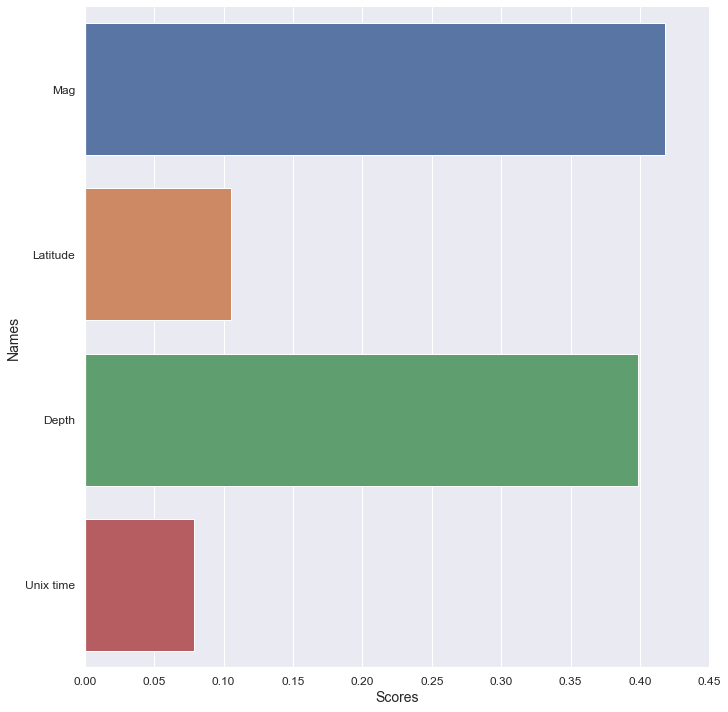

In [17]:
#visualize gini importance
features_lst = []
gini_score_lst = []
for feature, score in zip(cleaned_df_dropped[['mag', 'latitude', 'depth', 'Unix Time']],best_model.feature_importances_):
    features_lst.append(feature)
    gini_score_lst.append(score)
feature_lst = [feature.capitalize() for feature in features_lst]
d = {'Names': feature_lst, 'Scores': gini_score_lst}
gini_df = pd.DataFrame(d)

sns.set()

p = sns.catplot(y='Names', x="Scores", data=gini_df, kind='bar', height=10, aspect=1, legend=False)
p.set_ylabels(fontsize=14)
p.set_yticklabels(fontsize=12)
p.set_xticklabels(fontsize=12)
p.set_xlabels(fontsize=14)
plt.show()

Cross-Validation

In [18]:
#define number of splits fro cross-validation
k_fold = KFold(n_splits=10)
for train_indices, test_indices in k_fold.split(X):
    print('Train: %s | test: %s' % (train_indices, test_indices))


Train: [ 4490  4491  4492 ... 44888 44889 44890] | test: [   0    1    2 ... 4487 4488 4489]
Train: [    0     1     2 ... 44888 44889 44890] | test: [4490 4491 4492 ... 8976 8977 8978]
Train: [    0     1     2 ... 44888 44889 44890] | test: [ 8979  8980  8981 ... 13465 13466 13467]
Train: [    0     1     2 ... 44888 44889 44890] | test: [13468 13469 13470 ... 17954 17955 17956]
Train: [    0     1     2 ... 44888 44889 44890] | test: [17957 17958 17959 ... 22443 22444 22445]
Train: [    0     1     2 ... 44888 44889 44890] | test: [22446 22447 22448 ... 26932 26933 26934]
Train: [    0     1     2 ... 44888 44889 44890] | test: [26935 26936 26937 ... 31421 31422 31423]
Train: [    0     1     2 ... 44888 44889 44890] | test: [31424 31425 31426 ... 35910 35911 35912]
Train: [    0     1     2 ... 44888 44889 44890] | test: [35913 35914 35915 ... 40399 40400 40401]
Train: [    0     1     2 ... 40399 40400 40401] | test: [40402 40403 40404 ... 44888 44889 44890]


In [19]:
#calculate cross-validation score
from numpy import mean
from numpy import std

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_score=cross_val_score(best_model, X, y.values.ravel(), scoring='neg_mean_absolute_error', cv=k_fold, n_jobs=-1)
    print(cv_score)

# report performance
print('MAE: %.3f (%.3f)' % (mean(cv_score), std(cv_score)))

[ -7.37066051 -16.11303829  -6.82589375  -9.05935811 -11.22087798
 -11.20019471 -10.19108965  -9.60942529  -9.22029093  -9.62341332]
MAE: -10.043 (2.431)


In [20]:
#define tree for plot validation curve
reg_etrees = ExtraTreesRegressor(n_estimators=100, random_state=0)

In [21]:
#create elements for plot validation curve
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
param_range = np.linspace(1, 100, 5, dtype=int)
train_scores, test_scores = validation_curve(
    reg_etrees,
    X,
    y.values.ravel(),
    param_name="n_estimators",
    param_range=param_range,
    n_jobs=2,
    cv=10
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

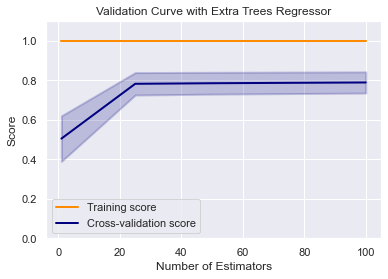

In [22]:
#plot validation curve
plt.title("Validation Curve with Extra Trees Regressor")
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [23]:
#use the best model to make predictions
testpred = best_model.predict(X_test)
actual_lon = y_test
lons = actual_lon['longitude'].tolist()
testpredict = []
abs_error = []
for item in testpred:
    testpredict.append(item)

maerr=mean_absolute_error(lons, testpredict)
test_mse = mean_squared_error(y_test, testpred)
rmse = sqrt(test_mse)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % maerr)

RMSE: 31.526
MAE: 8.701


In [24]:
#make dataframe with actual test values and ML predicted ones
lon_pred = actual_lon
lon_pred['Predicted'] = testpredict


In [25]:
lon_pred_all = lon_pred.rename(columns={'longitude': 'Actual'})

In [26]:
lon_pred_all.head(5)

,Actual,Predicted
20932,126.210700,102.894328
2503,-119.381667,-115.548507
6320,-112.521833,-113.294067
4336,-151.932500,-152.677324
4139,-116.837833,-116.999888


In [27]:
#join dataframes for actual and predicted with original dataframe
lon_pred_all = lon_pred.merge(model_df, how='inner', left_index=True, right_index=True)
lon_pred_all = lon_pred_all.rename(columns={'longitude_x': 'Actual', 'longitude_y': 'longitude'})
lon_pred_all.head(5)

,Actual,Predicted,time,latitude,longitude,depth,mag,magType,nst,gap,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix Time
20932,126.210700,102.894328,2022-02-13 15:00:15.296000+00:00,23.440600,126.210700,10.00,4.10,mb,NaN,142.0,...,"176 km SSE of Hirara, Japan",earthquake,11.40,2.00,0.303,3.0,reviewed,us,us,1.644764e+09
2503,-119.381667,-115.548507,2021-12-26 16:40:12.940000+00:00,37.490333,-119.381667,8.46,1.86,md,16.0,84.0,...,"30km NE of Oakhurst, CA",earthquake,0.53,2.42,0.245,14.0,reviewed,nc,nc,1.640537e+09
6320,-112.521833,-113.294067,2021-12-14 07:48:24.150000+00:00,46.887833,-112.521833,11.66,1.05,ml,9.0,114.0,...,"14 km ESE of Lincoln, Montana",earthquake,0.61,0.78,0.058,3.0,reviewed,mb,mb,1.639468e+09
4336,-151.932500,-152.677324,2021-12-20 15:49:33.630000+00:00,58.202900,-151.932500,10.30,1.70,ml,NaN,NaN,...,"45 km NE of Ouzinkie, Alaska",earthquake,NaN,0.30,NaN,NaN,automatic,ak,ak,1.640015e+09
4139,-116.837833,-116.999888,2021-12-21 00:26:38.010000+00:00,33.998333,-116.837833,11.38,0.75,ml,18.0,74.0,...,"9km NNE of Banning, CA",earthquake,0.22,0.49,0.155,6.0,reviewed,ci,ci,1.640046e+09


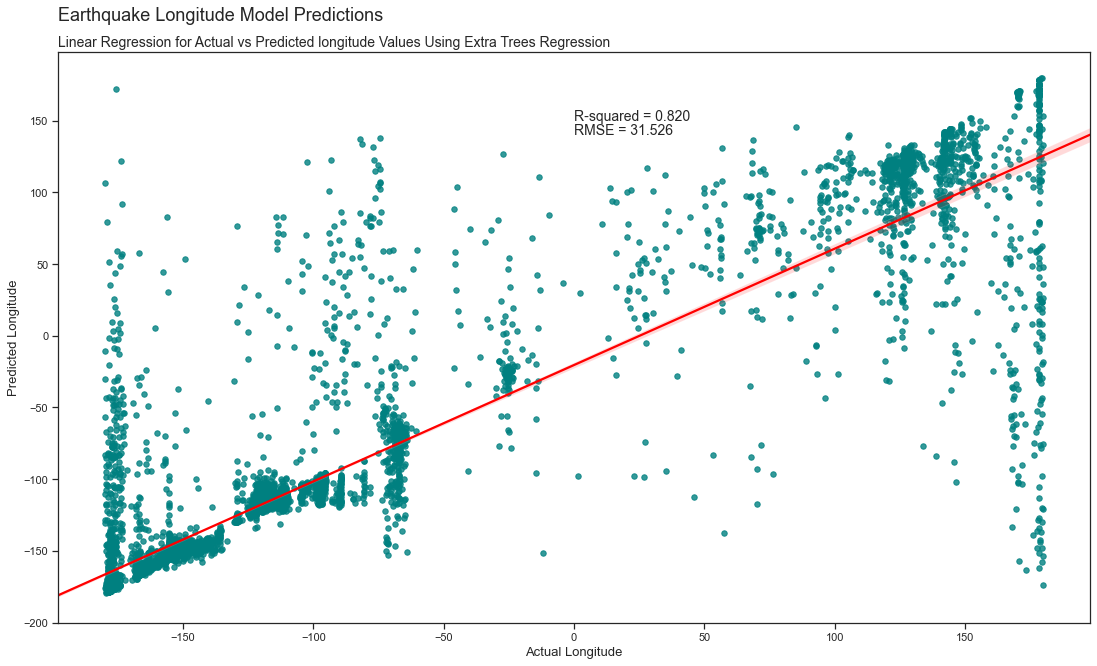

In [28]:
#plot actual vs predicted values
x = np.array(lon_pred_all['longitude'])
y = np.array(testpredict)
# r2_score(y_test, y_pred)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'teal'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Longitude', fontsize=13)
plt.xlabel('Actual Longitude',  fontsize=13)
# Bigger title
plt.suptitle('Earthquake Longitude Model Predictions', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted longitude Values Using Extra Trees Regression', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(lon_pred_all['longitude'], testpredict)), (0, 150),  fontsize=14)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 140), fontsize=14)

fig.savefig('../static/images/extratrees_lon_linear_sns.png', bbox_inches='tight',dpi=600)
plt.show()

In [29]:
# make a single prediction
from datetime import datetime
mag = float(input('Enter a magnitude: '))
lat = float(input('Enter a latitude (in decimal form; negative for south hemisphere): '))
depth = float(input('Enter a depth (in km, only numerical value): '))
date_input = input('Enter a date (yyyy/mm/dd): ')
time_input = input('Enter a time in UTC (HH:MM:SS): ')
datetime_str = date_input + ' '+ time_input
date_time_obj = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
date_time_unix = (time.mktime(date_time_obj.timetuple()))
single_features = [[mag,lat,depth,date_time_unix]]
y_pred = best_model.predict(single_features)
print('Predicted Longitude: %g' % y_pred)

Predicted Longitude: 72.9617


Test with new data from USGS


In [30]:
#obtain USGS data for the day
page_url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_day.csv"

test_df = pd.read_csv(page_url)
test_df


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-05-13T19:48:10.907Z,61.781300,-149.912900,21.900000,2.00,ml,NaN,NaN,NaN,0.74,...,2022-05-13T19:50:29.044Z,"7 km ENE of Willow, Alaska",earthquake,NaN,0.40,NaN,NaN,automatic,ak,ak
1,2022-05-13T19:47:39.640Z,19.156834,-155.367172,28.040001,2.42,ml,46.0,179.0,NaN,0.15,...,2022-05-13T19:53:09.760Z,"12 km ESE of Pāhala, Hawaii",earthquake,0.59,0.83,3.980,19.0,automatic,hv,hv
2,2022-05-13T19:45:18.120Z,35.695000,-117.609169,7.240000,3.08,ml,47.0,42.0,0.062790,0.17,...,2022-05-13T19:56:19.430Z,"10km NE of Ridgecrest, CA",earthquake,0.21,0.50,0.260,18.0,automatic,ci,ci
3,2022-05-13T19:28:35.740Z,33.521500,-116.740500,2.260000,0.52,ml,24.0,37.0,0.043870,0.18,...,2022-05-13T19:32:20.889Z,"7km WSW of Anza, CA",earthquake,0.25,0.35,0.154,16.0,automatic,ci,ci
4,2022-05-13T19:13:38.240Z,38.833168,-122.816002,1.730000,0.94,md,17.0,55.0,0.010800,0.03,...,2022-05-13T19:23:11.005Z,"8km NW of The Geysers, CA",earthquake,0.23,0.53,0.290,2.0,automatic,nc,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,2022-05-12T20:22:17.330Z,34.798167,-116.256500,4.010000,1.06,ml,10.0,138.0,0.071710,0.13,...,2022-05-12T20:44:42.038Z,"12km NW of Ludlow, CA",earthquake,0.34,0.66,0.195,4.0,reviewed,ci,ci
253,2022-05-12T20:13:15.340Z,40.726333,-111.804167,-2.000000,1.48,md,6.0,118.0,0.054530,0.16,...,2022-05-12T22:03:08.150Z,"2 km NE of Canyon Rim, Utah",quarry blast,1.04,31.61,0.462,4.0,reviewed,uu,uu
254,2022-05-12T20:10:22.880Z,37.276200,141.603500,53.280000,4.40,mb,NaN,126.0,2.820000,0.84,...,2022-05-12T20:30:55.040Z,"58 km ESE of Namie, Japan",earthquake,7.90,6.30,0.067,64.0,reviewed,us,us
255,2022-05-12T20:03:09.400Z,38.823502,-122.802002,3.170000,0.88,md,27.0,47.0,0.006306,0.02,...,2022-05-12T21:24:09.973Z,"6km NW of The Geysers, CA",earthquake,0.21,0.48,0.230,4.0,automatic,nc,nc


In [31]:
#create unix time column and drop columns not needed

test_df['Unix Time'] = pd.to_datetime(test_df['time']).astype(int)/10**9
cleaned_test_df = test_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_test_df



,latitude,longitude,depth,mag,Unix Time
0,61.781300,-149.912900,21.900000,2.00,1.652471e+09
1,19.156834,-155.367172,28.040001,2.42,1.652471e+09
2,35.695000,-117.609169,7.240000,3.08,1.652471e+09
3,33.521500,-116.740500,2.260000,0.52,1.652470e+09
4,38.833168,-122.816002,1.730000,0.94,1.652469e+09
...,...,...,...,...,...
252,34.798167,-116.256500,4.010000,1.06,1.652387e+09
253,40.726333,-111.804167,-2.000000,1.48,1.652386e+09
254,37.276200,141.603500,53.280000,4.40,1.652386e+09
255,38.823502,-122.802002,3.170000,0.88,1.652386e+09


In [32]:

#find if any column has NaNs
cleaned_test_df.isnull().sum()


latitude     0
longitude    0
depth        0
mag          0
Unix Time    0
dtype: int64

In [33]:

#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X_test_data = cleaned_test_df.drop(['longitude'], axis = 1)

y_test_data = cleaned_test_df[['longitude']]


In [34]:
#predict values with best model
pred_data_y = best_model.predict(X_test_data)


In [35]:
#create dataframe with values
test_pred_data = cleaned_test_df
test_pred_data['Predicted'] = pred_data_y
test_pred_data


,latitude,longitude,depth,mag,Unix Time,Predicted
0,61.781300,-149.912900,21.900000,2.00,1.652471e+09,-148.666862
1,19.156834,-155.367172,28.040001,2.42,1.652471e+09,-155.431839
2,35.695000,-117.609169,7.240000,3.08,1.652471e+09,-111.228404
3,33.521500,-116.740500,2.260000,0.52,1.652470e+09,-116.816055
4,38.833168,-122.816002,1.730000,0.94,1.652469e+09,-122.814612
...,...,...,...,...,...,...
252,34.798167,-116.256500,4.010000,1.06,1.652387e+09,-106.579025
253,40.726333,-111.804167,-2.000000,1.48,1.652386e+09,-113.532034
254,37.276200,141.603500,53.280000,4.40,1.652386e+09,125.398725
255,38.823502,-122.802002,3.170000,0.88,1.652386e+09,-122.803979


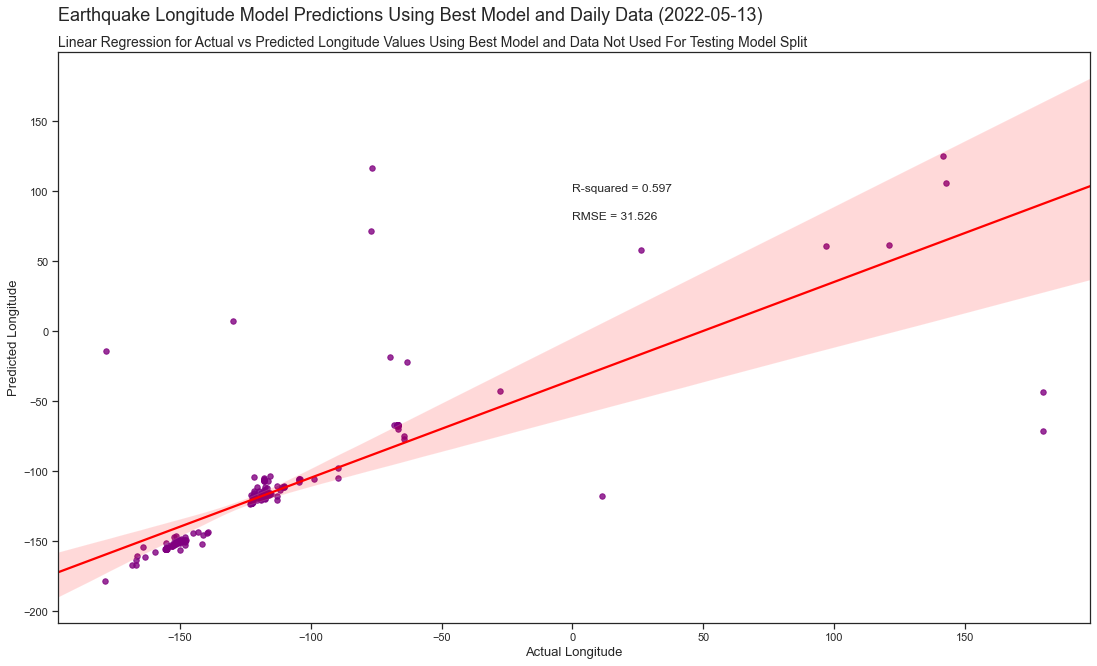

In [36]:
#create graph for actual vs predicted values
from datetime import date
today = date.today()

x = np.array(test_pred_data['longitude'])
y = np.array(test_pred_data['Predicted'])

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'purple'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Longitude', fontsize=13)
plt.xlabel('Actual Longitude',  fontsize=13)
# Bigger title
plt.suptitle(f'Earthquake Longitude Model Predictions Using Best Model and Daily Data ({today})', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Longitude Values Using Best Model and Data Not Used For Testing Model Split', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(x, y)), (0, 100),  fontsize=12)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 80), fontsize=12)

fig.savefig('../static/images/extratrees_lon_linear_sns_daily.png', bbox_inches='tight', dpi=600)
plt.show()

In [37]:
#connection to a PostgreSQL local database
# ===========================================

# user_name_var = input('What is the username of your database? ')
host_var = input('What is the host address of your database?')
pw = input("Enter the database password: ")
# db_name = input("Enter the name of the database: ")

string_output = "postgresql://postgres"+':'+pw+'@'+host_var+":5432"+'/earthquake_db'
engine = create_engine(string_output)
connection = engine.connect()
print("Connected to database...")
#create new database with predicted values for both training and test databases
#=============
#PostgreSQL
lon_pred_all.to_sql('earthquake_etrees_lon', engine, if_exists='replace', index = False)
#=============
#SQLite
cur = conn.cursor()
lon_pred_all.to_sql('earthquake_etrees_lon', conn, if_exists='replace', index=False)
# Close connection to SQLite database
conn.close()
connection.close()

Connected to database...
